# IAQ and Fitbit-Measured Sleep Exploration
Arguably the main attraction (for me at least), we explore the effect of IAQ parameters on Fitbit-measured sleep parameters.

In [196]:
import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Nightly Pollutant Exposures and Sleep Quality
The purpose of this notebook is to look at the in-depth relationships between IAQ and sleep quality, some of which has already been looked at in another notebook which has been copied here.

In [197]:
import os
import sys
sys.path.append('../')

from src.visualization import visualize
from src.analysis import iaq_and_sleep, ventilation

import pandas as pd
pd.set_option('display.max_columns', 200)
import numpy as np

import math
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns
import matplotlib.dates as mdates
from joypy import joyplot

import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy import stats

---

<a id="toc"></a>

# Table of Contents
1. [Data Import](#data_import)
2. [IAQ and Fitbit-Measured Sleep Quality](#fb)
    1. Summary
    2. [Factor Analysis](#factor_analysis)
    3. [Main Analysis](#fb_analysis)
    4. Ventilation
3. [IAQ and Self-Reported Sleep Quality](#ema)
    1. Pre-Processing
    2. [Main Analysis](#ema_analysis)

---

<a id="data_import"></a>

[Back to ToC](#toc)
# Data Import
For this analysis we need all reports of sleep quality in addition to the IEQ data and ventilation rates

### Fitbit Sleep Summary

In [198]:
fb_sleep = pd.read_csv("../data/processed/fitbit-sleep_summary-ux_s20.csv",parse_dates=["start_time","end_time","start_date","end_date"],infer_datetime_format=True)#,index_col=["beiwe","start_time"])
for stage in ["rem","nrem"]:
    fb_sleep[f"{stage}_percent"] = fb_sleep[f"{stage}_minutes"] / (fb_sleep["tst_fb"]*60)
fb_sleep.head()

,start_date,end_date,deep_count,deep_minutes,light_count,light_minutes,rem_count,rem_minutes,wake_count,wake_minutes,beiwe,efficiency,end_time,start_time,redcap,beacon,nrem_count,nrem_minutes,rem2nrem,tst_fb,rem_percent,nrem_percent,light_percent,deep_percent,waso,sol_fb,wol_fb
0,2020-05-14,2020-05-14,5.0,84.0,20.0,213.0,10.0,82.0,21.0,27.0,hfttkth7,93.349754,2020-05-14 07:13:00,2020-05-14 00:27:00,NaN,NaN,25.0,297.0,0.276094,6.316667,0.216359,0.783641,0.562005,0.221636,18.5,8.5,0.0
1,2020-05-14,2020-05-15,4.0,95.0,31.0,250.0,6.0,47.0,33.0,101.0,hfttkth7,79.513185,2020-05-15 08:06:30,2020-05-14 23:53:30,NaN,NaN,35.0,345.0,0.136232,6.533333,0.119898,0.880102,0.637755,0.242347,68.5,0.0,32.5
2,2020-05-15,2020-05-16,2.0,47.0,17.0,190.0,8.0,50.0,20.0,42.0,hfttkth7,87.234043,2020-05-16 04:57:00,2020-05-15 23:28:00,NaN,NaN,19.0,237.0,0.210970,4.783333,0.174216,0.825784,0.662021,0.163763,19.5,11.5,11.0
3,2020-05-17,2020-05-17,5.0,78.0,21.0,242.0,11.0,83.0,25.0,44.0,hfttkth7,90.156600,2020-05-17 09:28:30,2020-05-17 02:01:30,NaN,NaN,26.0,320.0,0.259375,6.716667,0.205955,0.794045,0.600496,0.193548,23.0,12.5,8.5
4,2020-05-18,2020-05-18,5.0,96.0,20.0,167.0,14.0,88.0,28.0,65.0,hfttkth7,84.375000,2020-05-18 07:20:00,2020-05-18 00:24:00,NaN,NaN,25.0,263.0,0.334601,5.850000,0.250712,0.749288,0.475783,0.273504,53.5,11.5,0.0


### Self-Report Sleep

In [199]:
beiwe_sleep = pd.read_csv("../data/processed/beiwe-morning_ema-ux_s20.csv",parse_dates=["timestamp"],infer_datetime_format=True)
beiwe_sleep.head()

,timestamp,beiwe,content,stress,lonely,sad,energy,tst,sol,naw,restful,redcap,beacon
0,2020-05-13 09:10:27,qh34m4r9,3,0.0,0.0,0.0,1.0,8.0,20.0,2.0,3.0,68,19.0
1,2020-05-13 09:15:49,awa8uces,0.0,2.0,1.0,1.0,1.0,2.0,10.0,3.0,1.0,28,26.0
2,2020-05-13 09:42:19,xxvnhauv,1,1.0,1.0,3.0,0.0,6.0,30.0,3.0,1.0,21,22.0
3,2020-05-13 09:43:27,rvhdl2la,1,1.0,2.0,3.0,0.0,5.3,5.0,2.0,2.0,29,NaN
4,2020-05-13 10:11:51,q5y11ytm,3,1.0,0.0,1.0,2.0,2.0,10.0,0.0,0.0,48,NaN


### Beacon IAQ
IAQ measurements courtesy of the beacons

In [200]:
ieq_raw = pd.read_csv("../data/processed/beacon_by_night-ux_s20.csv",parse_dates=["start_time","end_time",],infer_datetime_format=True)
ieq_raw = ieq_raw[(ieq_raw["home"] == 1) | (ieq_raw["increasing_co2"] > 0.5)]
ieq_raw = ieq_raw.groupby(["beacon","beiwe","redcap","start_time","end_time"]).median()
ieq_raw = ieq_raw.add_suffix("_median")
ieq_raw.reset_index(inplace=True)
ieq_raw.dropna(subset=["tvoc_median","co_median","co2_median","pm2p5_mass_median"],how="all",inplace=True)
ieq_ema_raw = ieq_raw[ieq_raw["ema_median"] == 1]
ieq_raw.drop(["home_median","increasing_co2_median","ema_median","no2_median"],axis="columns",inplace=True)
ieq_ema_raw.drop(["home_median","increasing_co2_median","ema_median","no2_median"],axis="columns",inplace=True)
ieq = ieq_raw.copy()
ieq_ema = ieq_ema_raw.copy()
ieq.head()

,beacon,beiwe,redcap,start_time,end_time,tvoc_median,lux_median,co_median,co2_median,pm1_number_median,pm2p5_number_median,pm10_number_median,pm1_mass_median,pm2p5_mass_median,pm10_mass_median,temperature_c_median,rh_median,fitbit_median
0,1,kyj367pi,10,2020-06-10 23:05:00,2020-06-11 09:14:00,69.472597,0.0,4.809835,607.609765,7.322099,7.641275,27.572210,0.456075,16.515731,1.898475,17.359939,39.483333,24.0
1,1,kyj367pi,10,2020-06-11 23:12:30,2020-06-12 09:14:30,210.569596,0.0,4.275798,630.040491,14.058337,13.393014,62.818538,0.892219,34.128077,2.004953,16.455691,40.436667,24.0
2,1,kyj367pi,10,2020-06-17 22:55:30,2020-06-18 08:51:30,310.293674,0.0,3.570167,616.201568,10.731803,10.305398,43.552369,0.656736,20.605142,1.909191,16.615442,45.706667,24.0
3,1,kyj367pi,10,2020-06-18 22:13:30,2020-06-19 08:42:00,300.139737,0.0,2.922652,598.332358,10.976217,10.498097,44.709340,0.671372,20.834074,1.908418,18.173762,46.830000,24.0
4,1,kyj367pi,10,2020-06-20 23:06:30,2020-06-21 07:43:00,307.701799,0.0,3.140130,585.162549,8.196889,8.283711,31.361368,0.504261,15.928621,1.884694,17.359939,47.862500,24.0


In [201]:
print(f"Beacons ({len(ieq['beacon'].unique())}): {ieq['beacon'].unique()}")

Beacons (20): [ 1  5  6  7 10 11 15 16 19 21 24 25 26 29 30 34 36 38 44 46]


### Beacon Ventilation Estimates
CO2-based ventilation rates

In [202]:
aer = pd.read_csv("../data/processed/beacon-ventilation.csv",parse_dates=["date"],infer_datetime_format=True)
#aer["end_date"] = pd.to_datetime(aer["end"].dt.date)
aer.head()

,beiwe,date,method,beacon,co2_mean,co2_delta,t_mean,t_delta,e,c0,v,ach,ending_co2_meas,ending_co2_calculated,rmse
0,745vq78e,2020-06-11,ss,5.0,1630.894481,-1.722181,26.893988,-0.000460,0.002664,836.009227,1188.0,0.359469,NaN,NaN,NaN
1,745vq78e,2020-06-12,ss,5.0,1460.549967,1.123542,27.377432,-0.022445,0.002668,836.009227,1188.0,0.458252,NaN,NaN,NaN
2,745vq78e,2020-06-14,ss,5.0,1397.203223,-0.824000,26.609234,-0.010191,0.002661,836.009227,1188.0,0.509207,NaN,NaN,NaN
3,745vq78e,2020-06-15,ss,5.0,1658.106142,-1.198516,26.826617,-0.011492,0.002663,836.009227,1188.0,0.361254,NaN,NaN,NaN
4,745vq78e,2020-06-17,ss,5.0,1299.296623,-0.502997,27.855932,-0.012368,0.002673,836.009227,1188.0,0.618737,NaN,NaN,NaN


---

<a id="fb"></a>

[Back to ToC](#toc)
# Fitbit-Measured Sleep
We start by looking at the response in Fitbit-measure sleep metrics

In [203]:
fb_sleep_and_iaq = iaq_and_sleep.device_sleep(data_dir="../data")

## Summary of Available Data
We just look at a few key values from the merged dataset.

In [204]:
fb_sleep_and_iaq.summarize(fb_sleep_and_iaq.sleep_and_iaq_data)

Number of Observations: 520
Number of Participants: 20
Observations per Participant:
kyj367pi:	26
745vq78e:	21
itmylz3g:	26
zdpffrox:	22
xlw5ntd5:	13
i31pt4b4:	23
9jtzsuu8:	25
e73a1pd5:	3
qh34m4r9:	48
lkkjddam:	78
xdbdrk6e:	11
vr9j5rry:	40
awa8uces:	27
tmexej5v:	43
idbkjh8u:	5
rnse61g4:	5
tlmlq19s:	69
olaxadz5:	25
4i7679py:	6
nvtfpaor:	4


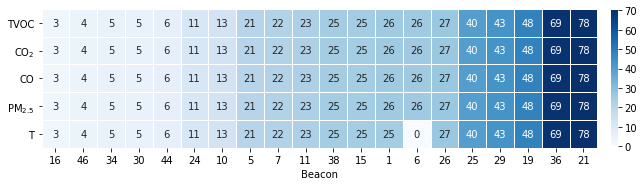

In [205]:
_ = fb_sleep_and_iaq.plot_data_availability_heatmap(fb_sleep_and_iaq.sleep_and_iaq_data,agg_str="_median",by_id="beacon",save=False)

<a id="factor_analysis"></a>

## Factor Analysis
In response to one of the reviewer's comments, we should do a factor analysis to understand if we need to include all the important IAQ parameters or just a few aggregations. In factor analysis, we look at how many variables truly explain the variability in the data. Some resources:

* [TDS Article with Example](https://towardsdatascience.com/factor-analysis-on-women-track-records-data-with-r-and-python-6731a73cd2e0)
* [DataCamp Walkthrough](https://www.datacamp.com/community/tutorials/introduction-factor-analysis)

### Adequacy Tests
Two tests to see if factor analysis is even warranted

#### Bartlett’s Test
Bartlett’s test of sphericity checks whether or not the observed variables intercorrelate at all using the observed correlation matrix against the identity matrix. If the test found statistically insignificant, you should not employ a factor analysis.

#### Kaiser-Meyer-Olkin Test 
The KMO Test measures the suitability of data for factor analysis. It determines the adequacy for each observed variable and for the complete model. KMO estimates the proportion of variance among all the observed variable. The lower proportion is, the more suitable for factor analysis. KMO values range between 0 and 1. A value of KMO less than 0.6 is considered inadequate.

### Choosing the Number of Factors
We will be using the variance explainability in addition to the loadings to see if we can reduce the number of factors that we use in the analysis. Currently, we are using 5 IAQ parameters, so we will see if we can explain the variability with 3 or 4 

In [206]:
es3, vs3, lds3, _, _ = fb_sleep_and_iaq.run_factor_analysis(fb_sleep_and_iaq.sleep_and_iaq_data, agg_str="_median", n_factors=3)
es4, vs4, lds4, _, _ = fb_sleep_and_iaq.run_factor_analysis(fb_sleep_and_iaq.sleep_and_iaq_data, agg_str="_median", n_factors=4)

Beacon 6 - temperature: There are likely no observations to fill in missing values with the mean.
Bartlett Test of Sphericity:
	Chi:	121.93275473444581
	p:	0.0
Kaiser-Meyer-Olkin Tes:
	KMO:	0.5704520327492382
Beacon 6 - temperature: There are likely no observations to fill in missing values with the mean.
Bartlett Test of Sphericity:
	Chi:	121.93275473444581
	p:	0.0
Kaiser-Meyer-Olkin Tes:
	KMO:	0.5704520327492382


<div class="alert alert-block alert-warning">
 
We have conflicting results here since Bartlett's Test says we should proceed, but the KMO test says we should not (although the value is very close to the cutoff of 0.6). We **will** proceed with some more analysis to see the number of factors that we are able to identify but with caution.
    
</div>

### Variances
The variances from either test are the same i.e. `vs3 == vs4`

In [207]:
vs3

[0.31627332807427166,
 0.5239259763065516,
 0.7244038621087551,
 0.8814426314646464,
 1.0000000000000002]

The first factor explains 31% of the variance, while including three factors explains 72% of the data. We could get away with four factors since they explain 88% of the covariance, but we should check the loadings to see if there are clear distinctions between the groups.

In [208]:
lds3

,RC1,RC2,RC3
tvoc,-0.026369,0.002256,0.141033
co,-0.059460,0.473669,0.240264
pm2p5,-0.470680,-0.036061,0.092458
co2,0.766846,0.208184,-0.106635
temperature,0.489930,-0.302890,0.292482


In [209]:
lds4

,RC1,RC2,RC3,RC4
tvoc,-0.030636,-0.009759,0.251977,-0.177474
co,-0.056526,0.379524,0.171158,0.026125
pm2p5,-0.558978,-0.078864,0.156313,0.179815
co2,0.696944,0.156015,0.027951,0.106823
temperature,0.453785,-0.290144,0.187952,0.048707


There are no clear groups present in the 3 or 4 factor groupings

<div class="alert alert-block alert-danger">
 
Looks like we do not need to use fewer, aggreagte factors in place of the five IAQ parameters that we consider (this is really a success, but the analysis failed hence the color).
    
</div>

[Back to Factor Analysis](#factor_analysis)

---

<a id="fb_analysis"></a>

# IAQ and Fitbit-Measured Sleep Quality
We can group each of the nights based on the median concentration value for each pollutant can compare that to sleep quality. However, to do so requires that we establish thresholds for low and high concentrations:
- **TVOCs**: The "short and long-term" [recommendation by the WHO](https://iaqscience.lbl.gov/voc-intro) is 100 ppb so `tvoc_threshold=100`
- **NO$_2$**: EPA provides outdoor standards where the most strict standard is the annual exposure limit at 53 ppb. The EPA's [discussion on indoor](https://www.epa.gov/indoor-air-quality-iaq/nitrogen-dioxides-impact-indoor-air-quality) NO$_2$ states that indoor concentration "[are] about half that of outdoors." Therefore, we will set `no2_threshold=25`. 
- **CO**: The WHO published a [study on CO guidelines](https://www.ncbi.nlm.nih.gov/books/NBK138710/) and recommended as low as 7 mg/m$^3$ which is approximately 6 ppm so `co_threshold=6`
- **CO$_2$**: [OSHA](https://ohsonline.com/Articles/2016/04/01/Carbon-Dioxide-Detection-and-Indoor-Air-Quality-Control.aspx?m=1&Page=2) and ASHRAE generally agree that concentrations above 1100 ppm tend to create some issues so `co2_threshold=1100`
- **PM2.5** (mass): Considering the EPA again, the outdoor annual exposure limit is 12 $\mu$g/m$^3$ and the [EPA mentions](https://www.epa.gov/indoor-air-quality-iaq/indoor-particulate-matter#Levels_in_Homes) that concentrations indoors would mirror outdoor concentrations absent of any indoor sources. However, that threshold is still too high so we use the median concentration from the study: `pm2p5_mass_threshold=1.5`
- **Temperature**: The ideal temperature range is between 60-67F which is lower than the minimum temperature that was measured. So we will use 27/80.6 (median temperature from the study) as a lower threshold and then increase slightly for the extra heat from the sensors so `temperature_c_threshold=27`.

## Visualizing and Running T-Test on Sleep Metrics
Now we can look at the distribution of sleep metrics for each pollutant profile and run a T-Test to see if there are _significant_ differences between the sleep metric results.

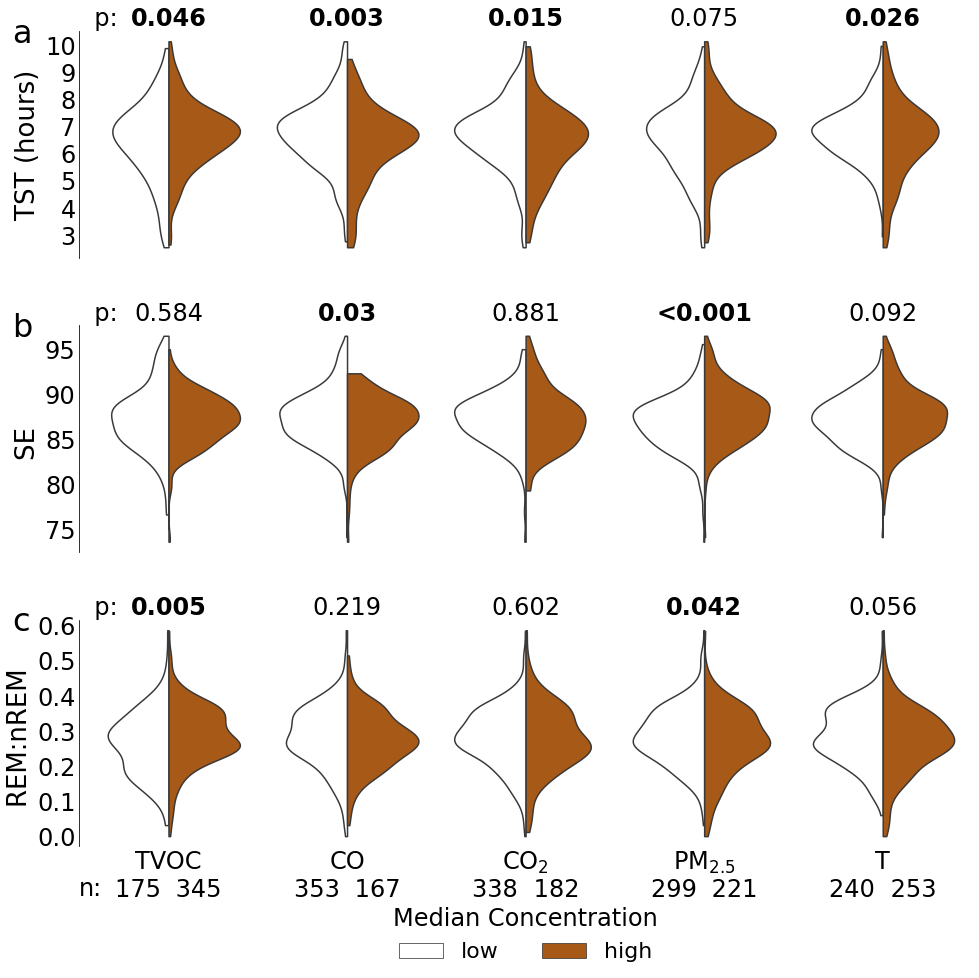

In [341]:
fb_res = fb_sleep_and_iaq.plot_sleep_quality_violins(fb_sleep_and_iaq.sleep_and_iaq_data)

## Getting Some Numeric Results
Looking at the mean differences between distributions

In [211]:
fb_res

{'tst':                low  high  mean_low  mean_high     p_val
 pollutant                                              
 tvoc           175   345  6.436000   6.677005  0.046441
 co             353   167  6.711520   6.351497  0.003217
 co2            338   182  6.697781   6.406685  0.015093
 pm2p5_mass     299   221  6.508473   6.714178  0.075490
 temperature_c  240   253  6.765139   6.511397  0.025876,
 'efficiency':                low  high   mean_low  mean_high     p_val
 pollutant                                               
 tvoc           175   345  87.300063  87.141156  0.584339
 co             353   167  87.398700  86.763287  0.030301
 co2            338   182  87.179609  87.222539  0.881425
 pm2p5_mass     299   221  86.745000  87.802963  0.000125
 temperature_c  240   253  87.041980  87.506573  0.092337,
 'rem2nrem':                low  high  mean_low  mean_high     p_val
 pollutant                                              
 tvoc           175   345  0.263018   0.286996

In [212]:
((fb_res["tst"].loc["pm2p5_mass","mean_low"]) - (fb_res["tst"].loc["pm2p5_mass","mean_high"]))*60

-12.342317529018292

In [213]:
(fb_res["efficiency"].loc["pm2p5_mass","mean_low"]) - (fb_res["efficiency"].loc["pm2p5_mass","mean_high"])

-1.057963443322592

In [214]:
(fb_res["efficiency"].loc["co","mean_low"]) - (fb_res["efficiency"].loc["co","mean_high"])

0.6354129750857851

In [215]:
(fb_res["rem2nrem"].loc["temperature_c","mean_low"] - fb_res["rem2nrem"].loc["temperature_c","mean_high"])

0.015593338580449534

[Back to Fitbit and Sleep Quality](#fb_analysis)

---

<a id="fb_and_ventilation"></a>

# Ventilation and Fitbit-Measured Sleep Quality
Now we look at the relationship between ventilation and Fitbit-measured sleep metrics

<a id="fb_sleep_distributions_and_ventilation"></a>

## Distributions of Sleep Metrics Based on Low/High Ventilation Rates
We can parse out the ventilation rates into `low` and `high` values by looking at some of the recommendations given by ASHRAE standard 62.2. The standard recommends a ventilation rate of 0.35 ACH per person. Most, if not all of our participants, should be the only occupants of their bedrooms. Therefore, we can use the 0.35 ACH as our cutoff point between the distributions.

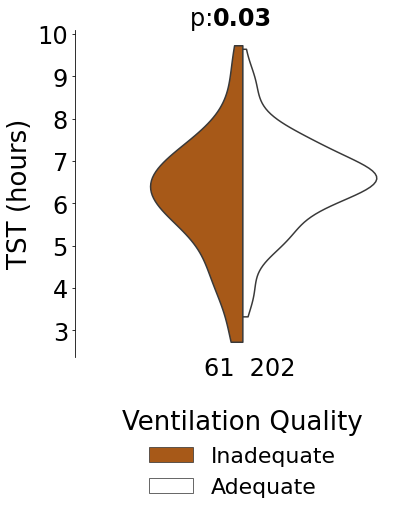

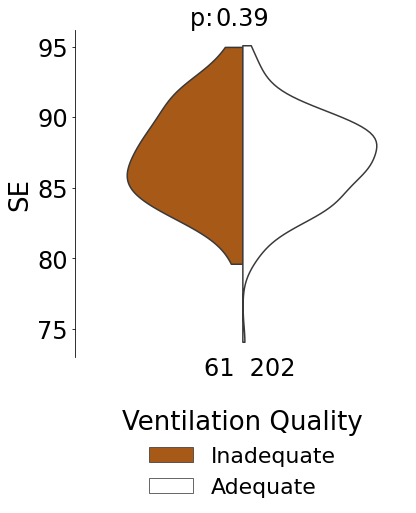

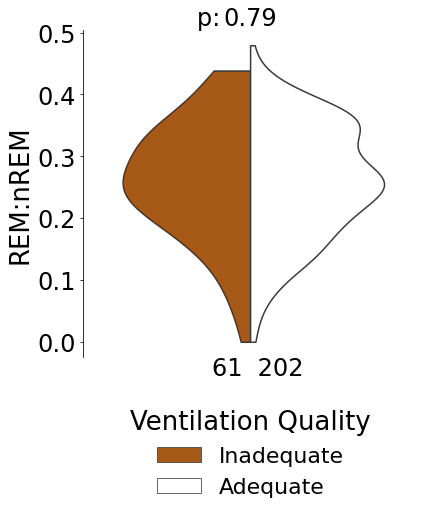

In [246]:
fibit_ventilation_res = pd.DataFrame()
for sm in ["tst_fb","efficiency","rem2nrem"]:
    temp = fb_sleep_and_iaq.plot_ventilation_violin(fb_sleep_and_iaq.sleep_and_aer_data,yvar=sm,save=False)
    fibit_ventilation_res = fibit_ventilation_res.append(temp)

In [229]:
fibit_ventilation_res

,low,high,mean_low,mean_high,p_val
Parameter,,,,,
tst_fb,61,202,6.136066,6.506436,0.032456
efficiency,61,202,87.352663,86.940160,0.386493
rem2nrem,61,202,0.263231,0.259437,0.786473


In [232]:
(fibit_ventilation_res.loc["tst_fb","mean_high"] - fibit_ventilation_res.loc["tst_fb","mean_low"])*60

22.22220418763186

<div class="alert alert-block alert-info">
 
TST seems to be sensitive to the ventilation rate when we consider 0.35 as the cutoff, with a difference in the mean TST of 22.2 minutes.
</div>

## Sleep Metric Response using Different ACH Thresholds
The 0.35 ACH as determined by ASHRAE might be fine, but what if we consider other scenarios:

1. **Estimation Errors**: Perhaps we _overestimate_ our ventilation rates and therefore 0.35 is too low of a cutoff. We should consider a higher threshold -- maybe double?
2. **Estimation Type**: In Notebook 4.1.1, one figure highlights that ventilation estimates from the steady-state calculation tend to be higher than for the decay method. Perhaps we should consider the two datasets separately and/or tailor the threshold to the estimation method?
3. **Participant Sensitivity**: Perhaps it is more appropriate to lable the ventilation rate as adequate/inadequate based on the participant's own measurements rather than some constant value. 

### Estimation Error
In this section, we consider different thresholds to label ventilation rates.

We start by visualizing the ventilation estimates to see if doubling the ventilation rate makes sense.

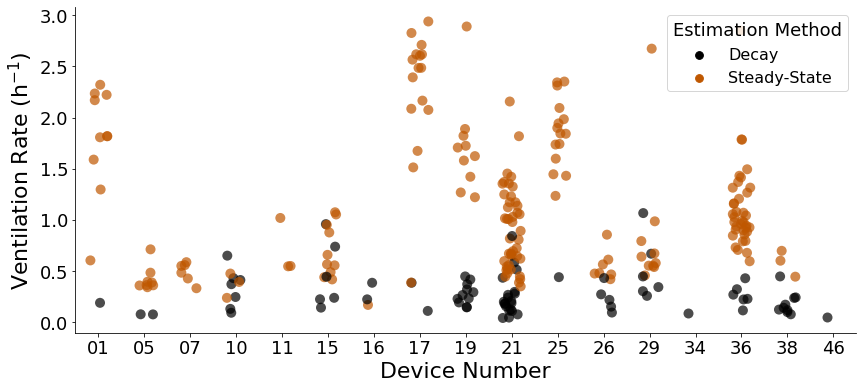

In [217]:
ventilation.plot_strip(fb_sleep_and_iaq.sleep_and_aer_data,save=False)

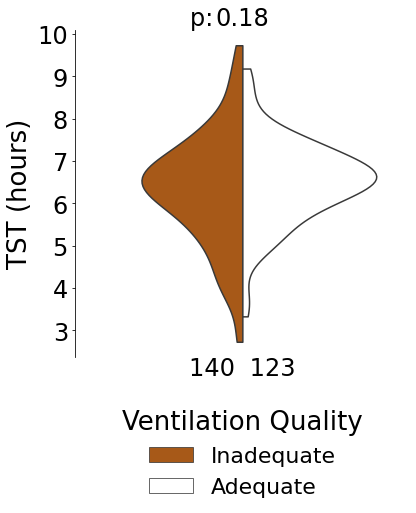

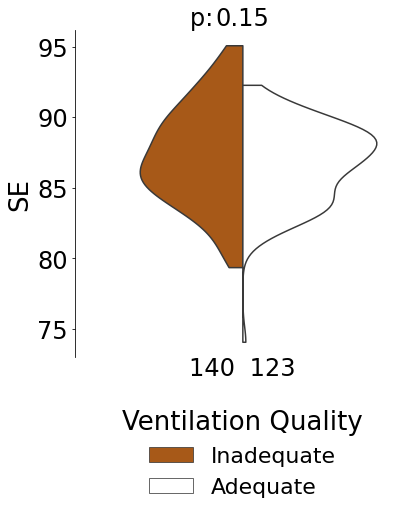

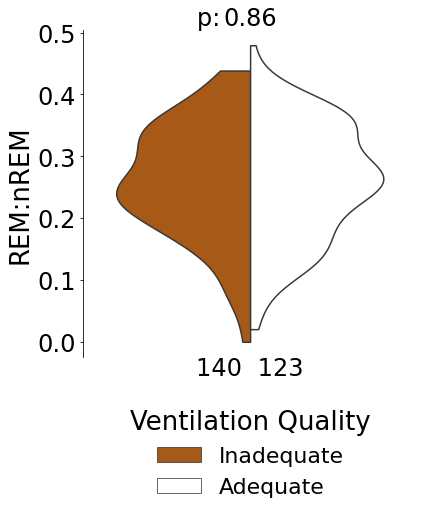

In [220]:
for sm in ["tst_fb","efficiency","rem2nrem"]:
    fb_sleep_and_iaq.plot_ventilation_violin(fb_sleep_and_iaq.sleep_and_aer_data,yvar=sm,threshold=0.7,save=False)

<div class="alert alert-block alert-info">
 
If we bump up the ACH, we get a _no_ siginificant differences in any of the Fitbit-measured sleep metrics.
</div>

### Estimation Type
The estimation type could be the issue since it is clear that the decay method results in lower ACH estimates.

First we look at the number of ventilation rates that we would classify as adequate or inadequate _per estimation method_ based on various thresholds.

In [236]:
for method in ["ss","decay"]:
    print(method.upper())
    vent_method = fb_sleep_and_iaq.sleep_and_aer_data[fb_sleep_and_iaq.sleep_and_aer_data["method"] == method]
    print(f"\tMean:\t{np.nanmedian(vent_method['ach'])}")
    for threshold in [0.35,0.7,1.]:
        print(f"\t{threshold}")
        n_low = len(vent_method[vent_method["ach"] <= threshold])
        n_high = len(vent_method[vent_method["ach"] > threshold])
        print(f"\t\tBelow:\t{n_low}\n\t\tAbove\t{n_high}")

SS
	Mean:	0.9888590126206762
	0.35
		Below:	4
		Above	179
	0.7
		Below:	64
		Above	119
	1.0
		Below:	92
		Above	91
DECAY
	Mean:	0.236
	0.35
		Below:	57
		Above	23
	0.7
		Below:	76
		Above	4
	1.0
		Below:	79
		Above	1


#### Steady-State
The median ACH is approximately 1 h$^{-1}$ which is a pretty nice threshold to consider for this estimation method.

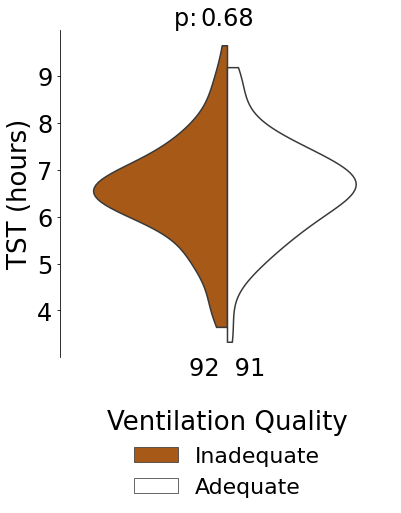

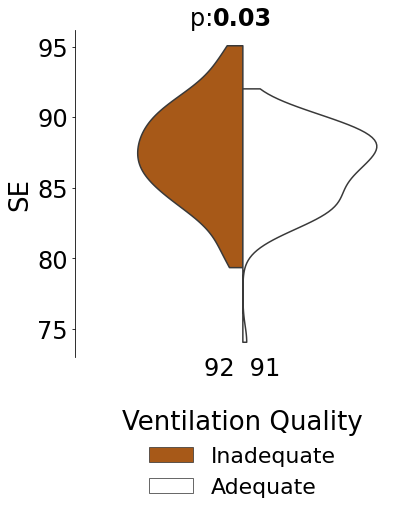

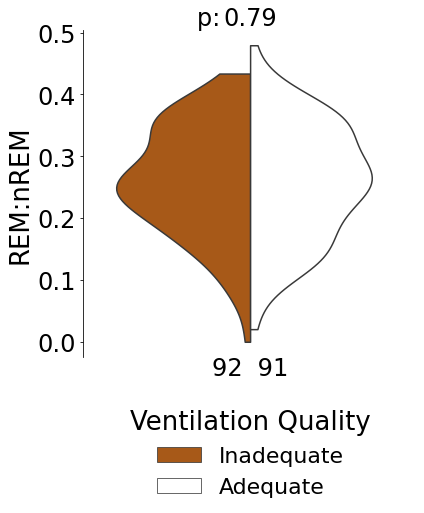

In [239]:
fibit_ss_res = pd.DataFrame()
for sm in ["tst_fb","efficiency","rem2nrem"]:
    temp = fb_sleep_and_iaq.plot_ventilation_violin(fb_sleep_and_iaq.sleep_and_aer_data[fb_sleep_and_iaq.sleep_and_aer_data["method"] == "ss"], yvar=sm,threshold=1,save=False)
    fibit_ss_res = fibit_ss_res.append(temp)

In [240]:
fibit_ss_res

,low,high,mean_low,mean_high,p_val
Parameter,,,,,
tst_fb,92,91,6.505435,6.570696,0.682370
efficiency,92,91,87.512667,86.465119,0.026641
rem2nrem,92,91,0.262027,0.258256,0.786295


<div class="alert alert-block alert-info">
 
Now the `se` is approximately 1.1% higher for nights with inadequate ventilation which contradicts our hypothesis.
</div>

#### Decay
The decay estimates are uncharacteristically low so rather than consider the median measurement, we use the 0.35 h$^{-1}$ from ASHRAE. 

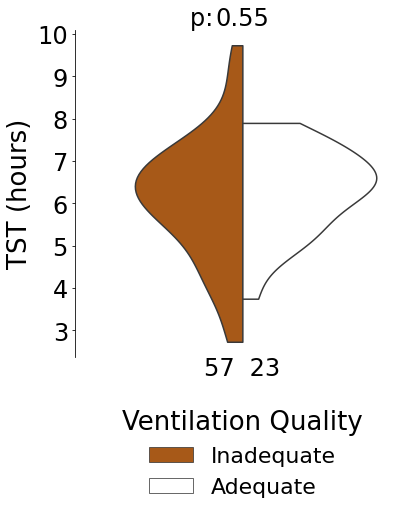

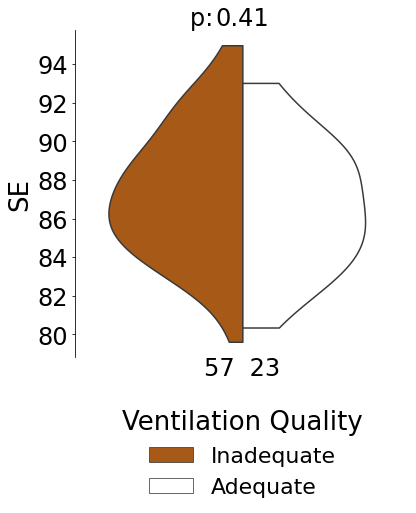

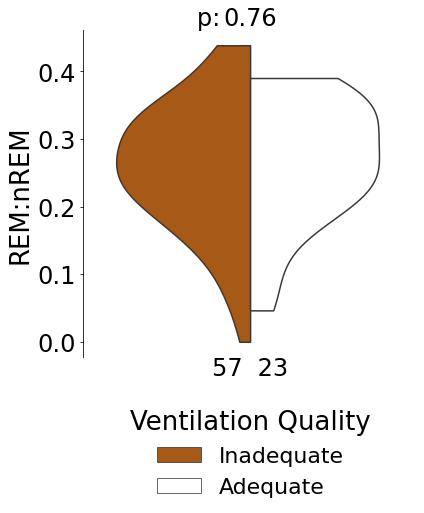

In [242]:
fibit_decay_res = pd.DataFrame()
for sm in ["tst_fb","efficiency","rem2nrem"]:
    temp = fb_sleep_and_iaq.plot_ventilation_violin(fb_sleep_and_iaq.sleep_and_aer_data[fb_sleep_and_iaq.sleep_and_aer_data["method"] == "decay"], yvar=sm,threshold=0.35,save=False)
    fibit_decay_res = fibit_decay_res.append(temp)

In [243]:
fibit_decay_res

,low,high,mean_low,mean_high,p_val
Parameter,,,,,
tst_fb,57,23,6.092982,6.298551,0.550384
efficiency,57,23,87.334210,86.647112,0.414078
rem2nrem,57,23,0.258585,0.266197,0.755165


<div class="alert alert-block alert-info">
 
Nothing sensitive to the ventilation quality when we consider just the estimates made by the decay method.
</div>

### Participant Sensitivity
Now the _likely_ best method to consider for this analysis.

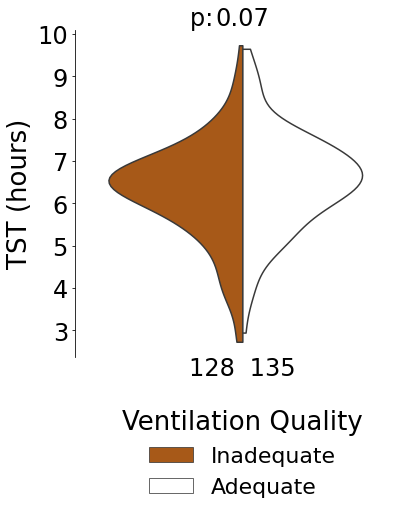

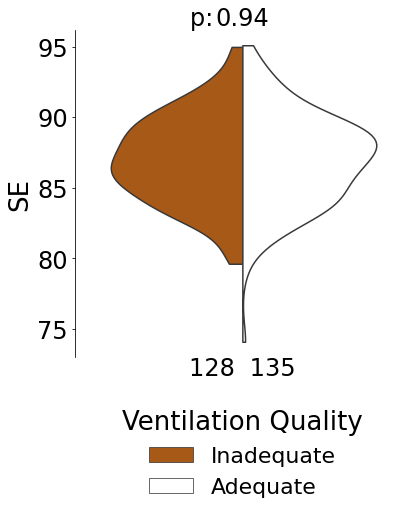

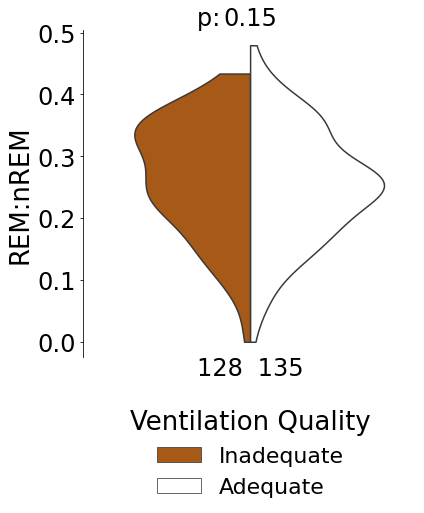

In [250]:
fibit_ventilation_pt_res = pd.DataFrame()
for sm in ["tst_fb","efficiency","rem2nrem"]:
    temp = fb_sleep_and_iaq.plot_ventilation_violin(fb_sleep_and_iaq.sleep_and_aer_data,yvar=sm,participant_based=True,save=False)
    fibit_ventilation_pt_res = fibit_ventilation_pt_res.append(temp)

<div class="alert alert-block alert-info">
 
Nothing sensitive to the ventilation quality when we base ventilation quality based on the participant median ventilation rate, but I still believe this to be the correct method. 
</div>

[Back to Fitbit Sleep Distributions and Ventilation](#fb_sleep_distributions_and_ventilation)

---

<a id="fb_sleep_bi_and_ventilation"></a>

## Binary Response in Fitbit-Measured Sleep Metrics to Ventilation Quality
Rather than look at the sleep metric distributions on an aggregate scale, we can separate everything out based on the participant. In this analysis, we will consider how sensitive the binary sleep metrics are to binary ventilation rates.

In [280]:
fb_sleep_bi_ventilation_bi = fb_sleep_and_iaq.examine_binary_relationship(fb_sleep_and_iaq.sleep_and_aer_data,participant_based=True)

We are using a contingency table and [Cramer's V](https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V) to assess the binary relationships. We are looking for high values for the Cramer's V score near 1.

In [281]:
for param, ct, score in zip(fb_sleep_bi_ventilation_bi["y"],fb_sleep_bi_ventilation_bi["ct"],fb_sleep_bi_ventilation_bi["score"]):
    print(param.upper())
    print(ct)
    print(score)
    print()

TST_FB
ach_quality     High  Low
tst_fb_quality           
High              71   67
Low               55   70
0.07446685661089064

EFFICIENCY
ach_quality         High  Low
efficiency_quality           
High                  66   73
Low                   60   64
0.009044005119432565

REM_PERCENT
ach_quality          High  Low
rem_percent_quality           
High                   55   77
Low                    71   60
0.12542691536281914



<div class="alert alert-block alert-info">
 
Using binary labels for the ventilation and sleep quality parameters did not seem to improve our outcome.
</div>

[Back to Fitbit Binary Sleep Response to Ventilation](#fb_sleep_bi_and_ventilation)

---

<a id="ema"></a>

[Back to ToC](#toc)
# Self-Report Sleep Metrics
Next, we see how the results change if we consider self-report sleep metrics.

In [328]:
bw_sleep_and_iaq = iaq_and_sleep.report_sleep(data_dir="../data")

## Pre-Processing
There are a few tweaks to the original dataset that we want to make.

### Removing Outliers
There are a few `sol` values that are uncharacteristically high

### Binary Restful and NAW Score
We can group the restfulness score into a binary output:
* negative: 0 or 1
* positive: 2 or 3

Similarly, NAW can be grouped based on:
* negative: 2 or more
* positive: less than 2

## Summarizing Results

In [330]:
bw_sleep_and_iaq.summarize(bw_sleep_and_iaq.sleep_and_iaq_data)

Number of Observations: 272
Number of Participants: 18
Observations per Participant:
kyj367pi:	13
745vq78e:	8
itmylz3g:	11
zdpffrox:	13
xlw5ntd5:	8
i31pt4b4:	9
9jtzsuu8:	18
qh34m4r9:	27
lkkjddam:	39
xdbdrk6e:	5
vr9j5rry:	22
awa8uces:	18
tmexej5v:	25
idbkjh8u:	1
rnse61g4:	3
tlmlq19s:	37
olaxadz5:	13
4i7679py:	2


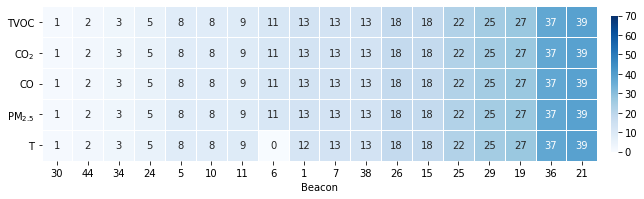

In [331]:
_ = bw_sleep_and_iaq.plot_data_availability_heatmap(bw_sleep_and_iaq.sleep_and_iaq_data,agg_str="_median")

---

<a id="ema_analysis"></a>

# IAQ and Self-Reported Sleep Quality

## Restfulness
Restfulness scores lend themselves to some analysis on the concentrations by grouping by score

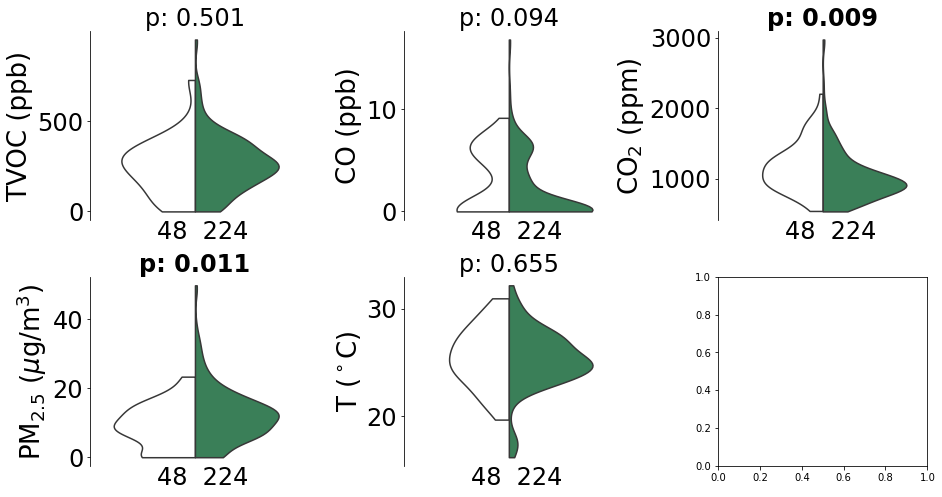

In [332]:
res_restful = bw_sleep_and_iaq.plot_iaq_violin(bw_sleep_and_iaq.sleep_and_iaq_data)

In [333]:
res_restful

,low,high,mean_low,mean_high,p_val
parameter,,,,,
tvoc_median,48,224,246.618681,263.857373,0.500717
co_median,48,224,3.068747,2.234595,0.094093
co2_median,48,224,1174.348968,1023.921660,0.009435
pm2p5_mass_median,48,224,8.925115,12.149027,0.010865
temperature_c_median,48,224,25.478099,25.269204,0.654850


In [334]:
res_restful.loc["pm2p5_mass_median","mean_low"] - res_restful.loc["pm2p5_mass_median","mean_high"]

-3.2239118901010144

### NAW

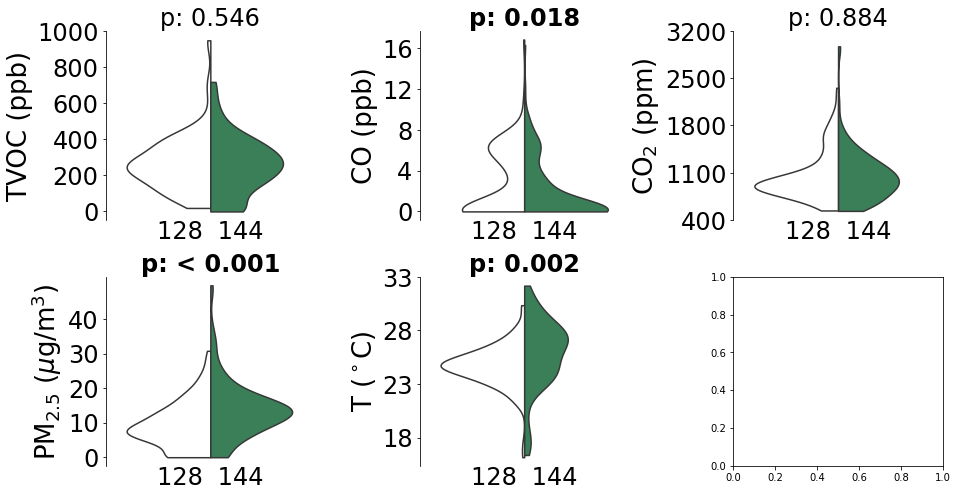

In [335]:
naw_res = bw_sleep_and_iaq.plot_iaq_violin(bw_sleep_and_iaq.sleep_and_iaq_data,targets=["tvoc","co","co2","pm2p5_mass","temperature_c"],sleep_metric="naw",hues=["High","Low"],
                             ticks={"tvoc":range(0,1200,200),"co":range(0,20,4),"co2":range(400,3900,700),"pm2p5_mass":range(0,50,10),"temperature_c":range(18,35,5)},
                             save=False)

In [336]:
naw_res.rename({"low":"naw_h","high":"naw_l","mean_low":"mean4naw_h","mean_high":"mean4naw_l"},axis=1,inplace=True)
naw_res

,naw_h,naw_l,mean4naw_h,mean4naw_l,p_val
parameter,,,,,
tvoc_median,128,144,267.065706,255.259291,0.545999
co_median,128,144,2.858480,1.958082,0.017677
co2_median,128,144,1053.914869,1047.403466,0.883757
pm2p5_mass_median,128,144,9.233615,13.665866,0.000003
temperature_c_median,128,144,24.711317,25.797528,0.001840


In [337]:
naw_res.loc["pm2p5_mass_median","mean4naw_h"] - naw_res.loc["pm2p5_mass_median","mean4naw_l"]

-4.432250882418815

In [338]:
(naw_res.loc["co_median","mean4naw_l"] - naw_res.loc["co_median","mean4naw_h"])

-0.9003981822638771

In [339]:
(naw_res.loc["temperature_c_median","mean4naw_l"] - naw_res.loc["temperature_c_median","mean4naw_h"])

1.0862111629902138

### TST and SOL

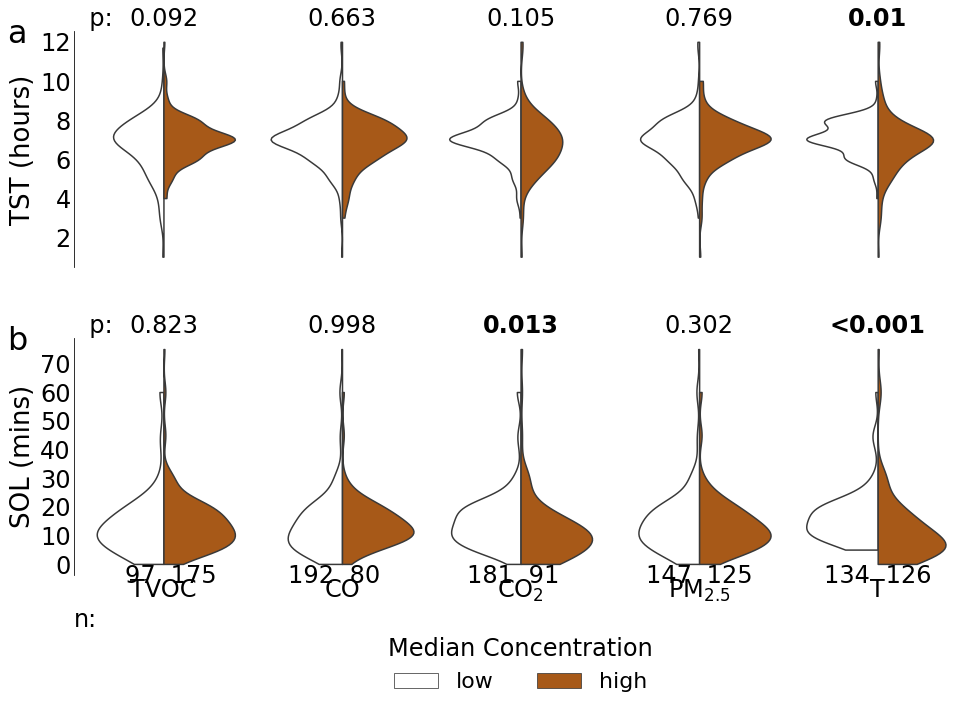

In [344]:
res_tst_sol = fb_sleep_and_iaq.plot_sleep_quality_violins(bw_sleep_and_iaq.sleep_and_iaq_data, limits=[200,4,1100,12,25.2], sleep_metrics=["tst","sol"], annot="all", sleep_modality="ema",save=False)

In [345]:
res_tst_sol

{'tst':                low  high  mean_low  mean_high     p_val
 pollutant                                              
 tvoc            97   175  6.704124   6.972000  0.091792
 co             192    80  6.897917   6.825000  0.663208
 co2            181    91  6.964088   6.702198  0.104509
 pm2p5_mass     147   125  6.855782   6.900800  0.768725
 temperature_c  134   126  7.113806   6.723413  0.010039,
 'sol':                low  high   mean_low  mean_high     p_val
 pollutant                                               
 tvoc            97   175  14.072165  14.382857  0.823117
 co             192    80  14.270833  14.275000  0.997725
 co2            181    91  15.436464  11.956044  0.013115
 pm2p5_mass     147   125  14.904762  13.528000  0.302277
 temperature_c  134   126  16.619403  12.023810  0.000821}

#### Mean Differences

In [346]:
(res_tst_sol["tst"].loc["temperature_c","mean_low"] - res_tst_sol["tst"].loc["temperature_c","mean_high"])*60

23.423596304193328

In [347]:
(res_tst_sol["sol"].loc["co2","mean_low"] - res_tst_sol["sol"].loc["co2","mean_high"])

3.4804201323538333

[Back to Main Analysis](#ema_analysis)

---

[Back to ToC](#toc)